# Table of Contents
1.[Gather](#Gather) <br>
2.[Assessment](#Assessment)<br>
3.[Clean](#Clean)<br>
4.[Finding a Winner](#jump1)<br>
5.[Distribution of Dog Ratings by Dog Types](#jump2)<br>
6.[Bayesian Probability by Rating & Breed](#jump3)<br>
7.[Time Series of WeRateDogs Tweets](#jump4)<br>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
#import tweepy
#from tweepy import OAuthHandler

#from timeit import default_timer as timer
#import twitter_credentials
import json
import re
import requests
%matplotlib inline

# Gather

###  Gathering Get Request

In [2]:
response = requests.get('https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv')
if response.status_code == 200:
    print('Success!')
elif response.status_code == 404:
    print('Not Found.')

Success!


In [3]:
images = pd.read_csv('image_predictions.tsv', sep = '\t', encoding = 'utf-8')

In [4]:
df_1 = pd.read_csv('twitter_archive_enhanced.csv',sep = ',')

auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_secret)

api = tweepy.API(auth, wait_on_rate_limit=True, wait_on_rate_limit_notify=True)
count = 0
fails_dict = {}
start = timer()
 Save each tweet's returned JSON as a new line in a .txt file
with open('tweet_json.txt', 'w') as outfile:
    # This loop will likely take 20-30 minutes to run because of Twitter's rate limit
    for tweet_id in tweet_ids:
        count += 1
        print(str(count) + ": " + str(tweet_id))
        try:
            tweet = api.get_status(tweet_id, tweet_mode='extended')
            print("Success")
            json.dump(tweet._json, outfile)
            outfile.write('\n')
        except tweepy.TweepError as e:
            print("Fail")
            fails_dict[tweet_id] = e
           
            pass
end = timer()
print(end - start)
print(fails_dict)


df_2 = pd.DataFrame(columns=['tweet_id','retweet count','favorite_count'])

with open('tweet_json.txt') as i:
    for line in i:
        stat = json.loads(line)
        tweet_id = stat['id_str']
        retweet_count = stat['retweet_count']
        favorite_count = stat['favorite_count']
        df_2 = df_2.append(pd.DataFrame([[tweet_id,retweet_count,
                                         favorite_count]], 
                                       columns=['tweet_id',
                                        'retweet_count', 'favorite_count']))
df_2.to_csv (r'C:\Users\tssan\Desktop\Udacity Projects\4wrangle\WeRateDogs.csv',
                          index = None, header=True, sep='\t', encoding='utf-8')

In [5]:
df_2 = pd.read_csv('WeRateDogs.csv', sep='\t',encoding='utf-8')

# Assessment
### Visual Assessment

In [6]:
df_1.loc[:3].style.applymap(lambda x: 'color: red' if pd.isnull(x) else '')

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,nan,nan,2017-08-01 16:23:56 +0000,Twitter for iPhone,This is Phineas. He's a mystical boy. Only ever appears in the hole of a donut. 13/10 https://t.co/MgUWQ76dJU,nan,nan,nan,https://twitter.com/dog_rates/status/892420643555336193/photo/1,13,10,Phineas,None,None,None,None
1,892177421306343426,nan,nan,2017-08-01 00:17:27 +0000,Twitter for iPhone,"This is Tilly. She's just checking pup on you. Hopes you're doing ok. If not, she's available for pats, snugs, boops, the whole bit. 13/10 https://t.co/0Xxu71qeIV",nan,nan,nan,https://twitter.com/dog_rates/status/892177421306343426/photo/1,13,10,Tilly,None,None,None,None
2,891815181378084864,nan,nan,2017-07-31 00:18:03 +0000,Twitter for iPhone,This is Archie. He is a rare Norwegian Pouncing Corgo. Lives in the tall grass. You never know when one may strike. 12/10 https://t.co/wUnZnhtVJB,nan,nan,nan,https://twitter.com/dog_rates/status/891815181378084864/photo/1,12,10,Archie,None,None,None,None
3,891689557279858688,nan,nan,2017-07-30 15:58:51 +0000,Twitter for iPhone,This is Darla. She commenced a snooze mid meal. 13/10 happens to the best of us https://t.co/tD36da7qLQ,nan,nan,nan,https://twitter.com/dog_rates/status/891689557279858688/photo/1,13,10,Darla,None,None,None,None


In [7]:
images.loc[:3].style.applymap(lambda x: 'color: red' if pd.isnull(x) else '')

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.0614285,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.0741917,True,Rhodesian_ridgeback,0.07201,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True


In [8]:
df_2.loc[:3].style.applymap(lambda x: 'color: red' if pd.isnull(x) else '')

,favorite_count,retweet count,retweet_count,tweet_id
0,37135,nan,7937,892420643555336193
1,31939,nan,5900,892177421306343426
2,24054,nan,3899,891815181378084864
3,40456,nan,8095,891689557279858688


### Programatic Assessment

In [9]:
df_1.count()

tweet_id                      2356
in_reply_to_status_id           78
in_reply_to_user_id             78
timestamp                     2356
source                        2356
text                          2356
retweeted_status_id            181
retweeted_status_user_id       181
retweeted_status_timestamp     181
expanded_urls                 2297
rating_numerator              2356
rating_denominator            2356
name                          2356
doggo                         2356
floofer                       2356
pupper                        2356
puppo                         2356
dtype: int64

- Five columns in the **df_1** Dataframe appear to contain missing values: 
    - **in_reply_to_status_id**, 
    - **in_reply_to_user_id**, 
    - **retweeed_status_id**, 
    - **retweeted_status_user_id**,  
    - **retweeted_status_timestamp** 


- As observed above:
    - **in_reply_to_status_id** and **in_reply_to_user_id** each have 2247 null values
    - **retweeed_status_id**, **retweeted_status_user_id**, and **retweeted_status_timestamp** each have 2094 null values


- The **text** column contains the body of the tweet, but then ends each tweet with a hyperlink.  The hyperlink is already represented in the **expanded_urls** column, so having it shown twice is redundant information and is not really part of the text of the tweet. 


- The columns **doggo**, **floofer**, **pupper**, and **puppo** have the string "None" in many of there rows. These columns seem to be categorical variables and would benefit by finding a melt them into a single categorical column.


- The **timestamp** column is formatted down to the millisecond. This is accurate and thourough information, but for future timeseries analysis, I will convert the time in a date format of yyyy/MM/dd HH:mm instead of the yyyy-MM-dd HH:mm:ss +ffff it is in now.



In [10]:
images.count()

tweet_id    2075
jpg_url     2075
img_num     2075
p1          2075
p1_conf     2075
p1_dog      2075
p2          2075
p2_conf     2075
p2_dog      2075
p3          2075
p3_conf     2075
p3_dog      2075
dtype: int64

- The columns **p1**, **p2**, and **p3** are all in snake case format and some of the categorical values are capitalized while others are not.  To clean this up I would like to remove the underscore(s) of each row and put the classications in title format 

In [11]:
df_2.count()

favorite_count    2166
retweet count        0
retweet_count     2166
tweet_id          2166
dtype: int64

**retweet count** is an inconsistent format by not having an underscore to replace the space between words. By grouping column names in snake case the column names of a dataframe are callable. This would likely be a column name that I renamed to much python convention for a column name but it looks like it is a duplicate column to **reteet_count** and has a majority of NaN values. I will drop the column **retweet count** to tidy up the **df_2** DataFrame.

##### Checking for Duplicate Rows

In [12]:
df_1.tweet_id.duplicated().any(), df_2.tweet_id.duplicated().any(), images.tweet_id.duplicated().any()

(False, True, False)

**df_2** contains some duplicated rows that will need to be dropped. 

In [13]:
doggo = df_1.doggo.value_counts()
floofer = df_1.floofer.value_counts()
pupper = df_1.pupper.value_counts()
puppo = df_1.puppo.value_counts()

print(f'{doggo},\n\n{floofer},\n\n{pupper},\n\n{puppo}')

None     2259
doggo      97
Name: doggo, dtype: int64,

None       2346
floofer      10
Name: floofer, dtype: int64,

None      2099
pupper     257
Name: pupper, dtype: int64,

None     2326
puppo      30
Name: puppo, dtype: int64


In [14]:
df_1.rating_numerator.value_counts().sort_index()

0         2
1         9
2         9
3        19
4        17
5        37
6        32
7        55
8       102
9       158
10      461
11      464
12      558
13      351
14       54
15        2
17        1
20        1
24        1
26        1
27        1
44        1
45        1
50        1
60        1
75        2
80        1
84        1
88        1
99        1
121       1
143       1
144       1
165       1
182       1
204       1
420       2
666       1
960       1
1776      1
Name: rating_numerator, dtype: int64

#### Defining a funtion printOut as a visual tool while parsing through the text to get a better look a numerators and denominators

In [15]:
def printOutRating(list1, list2,list3):
    for i in range(len(list1)):
        nex_list1 = list1[i]
        nex_list2 = list2[i]
        nex_list3 = list3[i]
        print(f'Row {nex_list1}\nDenominator:{nex_list2}\n{nex_list3} \n\n')

For most of the cases if a numerator had a value
greater than 14 it was only used once, however 75 occurs twice.
I decided to look into this a little further to figure out why this was.

In [16]:
printout = df_1[df_1.rating_numerator== 75]
        
ind  =  printout.index.tolist()
num  =  printout.rating_numerator.tolist()
text = printout.text.tolist()

printOutRating(ind,num,text)

Row 340
Denominator:75
RT @dog_rates: This is Logan, the Chow who lived. He solemnly swears he's up to lots of good. H*ckin magical af 9.75/10 https://t.co/yBO5wu… 


Row 695
Denominator:75
This is Logan, the Chow who lived. He solemnly swears he's up to lots of good. H*ckin magical af 9.75/10 https://t.co/yBO5wuqaPS 




By taking a closer look at these two tweets, I found two problems. The first is that the numerator is not 75, as it is listed in the df_1 dataset, its actually 10. The number 75 was misrepresented as the numerator in error when a rating of 9.75(a sneaky nod to the secret entrance of the Hogwarts Express on platform 9 and 3/4) was given to Logan and second, the indexed tweet #340 happens to be a duplicate of the indexed tweet #695 

In [17]:
df_1.rating_denominator.value_counts()

10     2333
11        3
50        3
80        2
20        2
2         1
16        1
40        1
70        1
15        1
90        1
110       1
120       1
130       1
150       1
170       1
7         1
0         1
Name: rating_denominator, dtype: int64

In [18]:
df_1.query('rating_denominator < 10').rating_denominator.count(),df_1.query('rating_denominator > 10').rating_denominator.count()

(3, 20)

2333 of the 2356 observations have a denominator of ten. I decided to look into this further to see if I could find out why this was. 
- 3 tweets have a denominator less than ten.
- 20 tweets have denominators greater than ten. 

In [19]:
printout = df_1[df_1.rating_denominator < 10]
    
ind = printout.index.tolist()
denom = printout.rating_denominator.tolist()
text = printout.text.tolist()

printOutRating(ind,denom,text)

Row 313
Denominator:0
@jonnysun @Lin_Manuel ok jomny I know you're excited but 960/00 isn't a valid rating, 13/10 is tho 


Row 516
Denominator:7
Meet Sam. She smiles 24/7 &amp; secretly aspires to be a reindeer. 
Keep Sam smiling by clicking and sharing this link:
https://t.co/98tB8y7y7t https://t.co/LouL5vdvxx 


Row 2335
Denominator:2
This is an Albanian 3 1/2 legged  Episcopalian. Loves well-polished hardwood flooring. Penis on the collar. 9/10 https://t.co/d9NcXFKwLv 




For the the denominators that had values less then ten
- From the the text printout we can see that Row 313 started with 960/00 but was then given the valid rating of 13/10 
- Row 516 was one of the few times where WeRateDogs did not give a rating.
- The tweet in row 2335 misrepresented the rating in error when a fraction of 1/2 was included in the text.

In [20]:
printout = df_1.loc[df_1.rating_denominator > 10]

ind = printout['rating_denominator'].index.tolist()
denom = printout['rating_denominator'].tolist()
text = printout['text'].tolist()

printOutRating(ind,denom,text)

Row 342
Denominator:15
@docmisterio account started on 11/15/15 


Row 433
Denominator:70
The floofs have been released I repeat the floofs have been released. 84/70 https://t.co/NIYC820tmd 


Row 784
Denominator:11
RT @dog_rates: After so many requests, this is Bretagne. She was the last surviving 9/11 search dog, and our second ever 14/10. RIP https:/… 


Row 902
Denominator:150
Why does this never happen at my front door... 165/150 https://t.co/HmwrdfEfUE 


Row 1068
Denominator:11
After so many requests, this is Bretagne. She was the last surviving 9/11 search dog, and our second ever 14/10. RIP https://t.co/XAVDNDaVgQ 


Row 1120
Denominator:170
Say hello to this unbelievably well behaved squad of doggos. 204/170 would try to pet all at once https://t.co/yGQI3He3xv 


Row 1165
Denominator:20
Happy 4/20 from the squad! 13/10 for all https://t.co/eV1diwds8a 


Row 1202
Denominator:50
This is Bluebert. He just saw that both #FinalFur match ups are split 50/50. Amazed af. 11/10 https:

### Summary of Assessment

#### Quality issues
**df_1** dataset
- The columns **in_reply_to_status_id**,**in_reply_to_user_id**,**retweeted_status_id**, **retweeted_status_user_id**,**retweeted_status_timestamp** have almost all NaN values
- After accessing the ‘rating_denomiator’ field, I found that 2333 of the 2356 observations have a denominator of ten. 
- 3 tweets have a denominator less than ten.
- 20 tweets have denominators greater than ten.
- Row 313 started with 960/00 but was then given the valid rating of 13/10. These ratings need to be swapped in **df_1** 
- The tweet in row 342 was not a rating, but a reply to question asking for the date that the twitter account began.
- The tweet in row 516 was not given a rating
- Some tweets contain fractions in the body of the text that have been misrepresent as the rating
- Tweets with decimal points show incorrect ratings than what they were actually given
- The rows with denominator that are greater than 10 are valid, but to be able to compare them with the rest, I will need to standardize them to the value of 10. 
- Timestamp would be more interpretable if it were in a format of yyyy/MM/dd HH:mm instead of the yyyy-MM-dd HH:mm:ss +ffff it has in the dataset.
- The ‘text’ contains the body of the tweet, but then ends each tweet with a hyperlink.  The hyperlink is already represented in the ‘expanded_urls’ column, so having it shown twice is redundant information.


**df_2** dataset
- tweet_json has duplicate rows that need to be dropped
- In the tweet_json file ‘retweet count’ has an inconsistent format by not having an underscore to replace the space between words. It is a duplicate column to ‘reteet_count’ and has all NaN values. 
- stuff

**images** dataset
- ‘p1’, ‘p2’, and ‘p3’ are all in snake case format and some of the categorical values are capitalized while others are not.

#### Tidiness Issues
**df_1** dataset 
- The columns Doggo, Pupper, Floofer, and Puppo need to be melted into one column
- After ‘rating_denominator’ values were set to 10, I dropped the column and renamed ‘rating_numerator’ to the general ‘rating’

**all datasets** - Will need to merged twitter_archive_enhanced, tweet_json, and image_prediction Dataframes into one Dataframe twitter_archive_master.csv

# Clean

In [21]:
df_1_cln = df_1.copy()
df_2_cln = df_2.copy()
images_cln = images.copy()

## Fixing Quality Issues

##### Define
- 1. Drop the columns **in_reply_to_status_id**,**in_reply_to_user_id**,**retweeted_status_id**, **retweeted_status_user_id**,**retweeted_status_timestamp** with NaN values from the **df_1** dataset

##### Code

In [22]:
df_1_cln.drop(columns=['in_reply_to_status_id','in_reply_to_user_id','retweeted_status_id',
                   'retweeted_status_user_id','retweeted_status_timestamp'
                   ], inplace=True)

##### Test the results

In [23]:
df_1_cln.columns

Index(['tweet_id', 'timestamp', 'source', 'text', 'expanded_urls',
       'rating_numerator', 'rating_denominator', 'name', 'doggo', 'floofer',
       'pupper', 'puppo'],
      dtype='object')

##### Define 
- Column 'retweet count' has no values, and is a duplicate column name of 'retweet_count'. Because of this, the column should be dropped from **df_2**

##### Code

In [24]:
df_2_cln.drop(columns={'retweet count'},inplace=True)

##### Test the results

In [25]:
if 'retweet count' in df_2_cln.columns :
    print("\nThis column exists in Dataframe")
else :
    print("\nThis column does not exists in Dataframe")


This column does not exists in Dataframe


##### Define
- 2. The tweet in row 342 was not a rating, but a reply to question asking for the date that the twitter account began.


In [26]:
df_1_cln.loc[342,:],df_1_cln.loc[342,'text']

(tweet_id                                             832088576586297345
 timestamp                                     2017-02-16 04:45:50 +0000
 source                <a href="http://twitter.com/download/iphone" r...
 text                           @docmisterio account started on 11/15/15
 expanded_urls                                                       NaN
 rating_numerator                                                     11
 rating_denominator                                                   15
 name                                                               None
 doggo                                                              None
 floofer                                                            None
 pupper                                                             None
 puppo                                                              None
 Name: 342, dtype: object, '@docmisterio account started on 11/15/15')

#####  Code

In [27]:
df_1_cln.drop([342],inplace=True)

##### Test the results

In [28]:
if 342 in df_1_cln.index :
    print("\nThis value exists in Dataframe")
else :
    print("\nThis value does not exists in Dataframe")


This value does not exists in Dataframe


##### Define
- 3.  Fixing row #516 (No rating given) in the **df_1** dataset

In [29]:
df_1.loc[516,:],df_1.loc[516,'text']

(tweet_id                                                     810984652412424192
 in_reply_to_status_id                                                       NaN
 in_reply_to_user_id                                                         NaN
 timestamp                                             2016-12-19 23:06:23 +0000
 source                        <a href="http://twitter.com/download/iphone" r...
 text                          Meet Sam. She smiles 24/7 &amp; secretly aspir...
 retweeted_status_id                                                         NaN
 retweeted_status_user_id                                                    NaN
 retweeted_status_timestamp                                                  NaN
 expanded_urls                 https://www.gofundme.com/sams-smile,https://tw...
 rating_numerator                                                             24
 rating_denominator                                                            7
 name                       

#####  Code

In [30]:
df_1_cln.loc[516, 'rating_numerator']= np.median(df_1_cln.rating_numerator)
df_1_cln.loc[516, 'rating_denominator']= np.median(df_1_cln.rating_denominator)

In [31]:
print(f"Since Sam was never given a rating, I gave him the median rating which is {df_1_cln.loc[516,'rating_numerator']}/{df_1_cln.loc[516,'rating_denominator']}")

Since Sam was never given a rating, I gave him the median rating which is 11.0/10.0


##### Define
- 4.Dropping the duplicate in the **df_2** dataset

In [32]:
len(df_2_cln)

2166

In [33]:
df_2_cln = df_2_cln.drop_duplicates(subset=['tweet_id'],keep='first').reset_index()

##### Test the results

In [34]:
df_2_cln.tweet_id.duplicated().any()

False

In [35]:
len(df_2_cln)

2026

##### Define
- 5. Replacing all mislabeled ratings with the correct rating

In [36]:
indices = []
for i, row in df_1_cln.iterrows():
    if df_1_cln.rating_denominator[i] != 10:
        in_str= row['text']
        try:
            test = re.search(r'\d+(?:\.\d+)?/10', in_str).group()
            den = re.findall(r'\d+', test)[1]
            test = re.findall(r'\d+', test)[0]
            df_1_cln.at[i,'rating_numerator'] = test
            df_1_cln.at[i,'rating_denominator'] = den
            indices.append(i)
        except:
            test = 'Unchanged'
        if test == 'Unchanged':
            denominator = 'Unchanged'
        else:
            denominator = den
                
        print(f'Row {i}\nNumerator {test}\nDenominator: {denominator}\n{in_str}\n')
        
    else:
        pass

Row 313
Numerator 13
Denominator: 10
@jonnysun @Lin_Manuel ok jomny I know you're excited but 960/00 isn't a valid rating, 13/10 is tho

Row 433
Numerator Unchanged
Denominator: Unchanged
The floofs have been released I repeat the floofs have been released. 84/70 https://t.co/NIYC820tmd

Row 784
Numerator 14
Denominator: 10
RT @dog_rates: After so many requests, this is Bretagne. She was the last surviving 9/11 search dog, and our second ever 14/10. RIP https:/…

Row 902
Numerator Unchanged
Denominator: Unchanged
Why does this never happen at my front door... 165/150 https://t.co/HmwrdfEfUE

Row 1068
Numerator 14
Denominator: 10
After so many requests, this is Bretagne. She was the last surviving 9/11 search dog, and our second ever 14/10. RIP https://t.co/XAVDNDaVgQ

Row 1120
Numerator Unchanged
Denominator: Unchanged
Say hello to this unbelievably well behaved squad of doggos. 204/170 would try to pet all at once https://t.co/yGQI3He3xv

Row 1165
Numerator 13
Denominator: 10
Happy 4/

##### Test the results

In [37]:
for i in range(len(indices)):
    ind = indices[i]
    num = df_1_cln.rating_numerator[indices[i]]
    den = df_1_cln.rating_denominator[indices[i]]
    print(f'Row {ind} has a rating of {num}/{den}')

Row 313 has a rating of 13.0/10.0
Row 784 has a rating of 14.0/10.0
Row 1068 has a rating of 14.0/10.0
Row 1165 has a rating of 13.0/10.0
Row 1202 has a rating of 11.0/10.0
Row 1662 has a rating of 10.0/10.0
Row 2335 has a rating of 9.0/10.0


##### Define
- 6. Normalizing Denominators to a Standard of 10 structuring data to facilitate analysis **df_1**

#####  Code

In [38]:
norm_numerator= []
norm_denominator= []
for i, row in df_1_cln.iterrows():
    norm = 10 / row['rating_denominator']
    num = row['rating_numerator'] = row['rating_numerator']* norm
    norm_numerator.append(num)
    den = row['rating_denominator'] = row['rating_denominator']* norm
    norm_denominator.append(den)

In [39]:
df_1_cln['rating_numerator'] = norm_numerator
df_1_cln['rating_denominator'] = norm_denominator

##### Test the results

In [40]:
df_1_cln.query('rating_denominator !=10')['rating_denominator'].any()

False

In [41]:
df_1_cln.rating_denominator.value_counts()

10.0    2355
Name: rating_denominator, dtype: int64

In [42]:
df_1_cln.rating_numerator.value_counts()

12.0      562
11.0      471
10.0      463
13.0      353
9.0       158
8.0       102
14.0       56
7.0        54
5.0        37
6.0        32
3.0        19
4.0        15
2.0        10
1.0         8
0.0         2
75.0        2
15.0        2
420.0       2
17.0        1
666.0       1
12.5        1
1776.0      1
26.0        1
27.0        1
182.0       1
Name: rating_numerator, dtype: int64

##### Define
- 7.  Correcting Ratings Containing Decimal Places, Using Regular Expression to loop through each text and pull out any digits with decimal places in the **df_1** dataset

#####  Code

In [43]:
for i, row in df_1_cln.iterrows():
    in_str= row['text']
    split = re.split(r'/' , in_str)[0]
    if bool(re.search(r'\d+\.\d+$', split)) == True:
        after = re.findall(r'\d+\.\d+', split)[0]
        before = df_1_cln.loc[i, 'rating_numerator']
        df_1_cln.loc[i, 'rating_numerator'] = after
        print(f"The rating in row {i} used to be {before} and now is {after}.")
    else:
        pass

The rating in row 45 used to be 5.0 and now is 13.5.
The rating in row 340 used to be 75.0 and now is 9.75.
The rating in row 695 used to be 75.0 and now is 9.75.
The rating in row 763 used to be 27.0 and now is 11.27.
The rating in row 1689 used to be 5.0 and now is 9.5.
The rating in row 1712 used to be 26.0 and now is 11.26.


In [44]:
df_1_cln.rating_numerator.dtype

dtype('O')

In [45]:
df_1_cln['rating_numerator'] = df_1_cln['rating_numerator'].astype('float64')

##### Test the results

In [46]:
check = df_1_cln.rating_numerator
text = df_1_cln.text
divide = "---" * 38

for i in range(len(check)):
    try:
        chk_dec = check[i]
        txt = text[i] 
        if bool(chk_dec.is_integer()) == False:
            print(f'Now row {i} has the correct rating of {chk_dec}.\n\n{txt}\n{divide}\n')
        else:
            pass
    except:
        pass

Now row 45 has the correct rating of 13.5.

This is Bella. She hopes her smile made you smile. If not, she is also offering you her favorite monkey. 13.5/10 https://t.co/qjrljjt948
------------------------------------------------------------------------------------------------------------------

Now row 340 has the correct rating of 9.75.

RT @dog_rates: This is Logan, the Chow who lived. He solemnly swears he's up to lots of good. H*ckin magical af 9.75/10 https://t.co/yBO5wu…
------------------------------------------------------------------------------------------------------------------

Now row 695 has the correct rating of 9.75.

This is Logan, the Chow who lived. He solemnly swears he's up to lots of good. H*ckin magical af 9.75/10 https://t.co/yBO5wuqaPS
------------------------------------------------------------------------------------------------------------------

Now row 763 has the correct rating of 11.27.

This is Sophie. She's a Jubilant Bush Pupper. Super h*ckin rare. 

##### Define
- 8. Now that all the decimal places are accounted for, I will round to the nearest integer, to keep the ratings on a discrete scale.

#####  Code

In [47]:
# Rounding Ratings to get a discrete scale
for i, row in df_1_cln.iterrows():
    before = df_1_cln.loc[i, 'rating_numerator']
    after = round(df_1_cln.rating_numerator[i], 0)
    df_1_cln.loc[i, 'rating_numerator'] = after
    if bool(before == after) == False :
        print(f"The rating in row {i} used to be {before} and now it is {after}.")
    else:
        pass

The rating in row 45 used to be 13.5 and now it is 14.0.
The rating in row 340 used to be 9.75 and now it is 10.0.
The rating in row 695 used to be 9.75 and now it is 10.0.
The rating in row 763 used to be 11.27 and now it is 11.0.
The rating in row 1663 used to be 12.5 and now it is 12.0.
The rating in row 1689 used to be 9.5 and now it is 10.0.
The rating in row 1712 used to be 11.26 and now it is 11.0.


##### Test the results

In [48]:
check = df_1_cln.rating_numerator
tally = []
for i in range(len(check)):
    try:
        chk_dec = check[i]
        chk = chk_dec.is_integer()
        tally.append(not chk)
    except:
        pass
if bool(any(tally)) == True:
    n = len(tally)
    print(f'Some of the {n} tweets failed the test')
else:
    n = len(tally)
    print(f'All {n} tweets passed the test successfully!')

All 2354 tweets passed the test successfully!


##### Define
- 9. Set the datatype of **rating_numerator** from a float64 to and integer.

In [49]:
df_1_cln.rating_numerator.dtype

dtype('float64')

#####  Code

In [50]:
df_1_cln.rating_numerator = df_1_cln.rating_numerator.astype(int) 

##### Test the results

In [51]:
df_1_cln.rating_numerator.dtype

dtype('int32')

##### Define
- 11. The columns **p1**, **p2**, and **p3** are all in snake case format and some of the categorical values are capitalized while others are not.  To clean this up I would like to remove the underscore(s) of each row and put the classications in title format 

##### Code

In [52]:
pvals = ['p1', 'p2', 'p3']

def removeSnake(word):
        return ''.join(x.lower() or '_' for x in word.replace('_', ' '))
for p in pvals: 
    exec(f"images_cln.{p} = images_cln.{p}.apply(lambda x : removeSnake(x))")

##### Test the results

In [53]:
images_cln[['p1','p2','p3']].sample(10)

,p1,p2,p3
221,toy poodle,miniature poodle,chow
1200,malamute,samoyed,siberian husky
296,tub,bathtub,swimming trunks
963,staffordshire bullterrier,american staffordshire terrier,bull mastiff
733,cheeseburger,hotdog,bagel
735,labrador retriever,chesapeake bay retriever,german short-haired pointer
828,dining table,grey fox,siamese cat
1338,labrador retriever,chihuahua,american staffordshire terrier
512,hamster,guinea pig,broccoli
70,rottweiler,miniature pinscher,black-and-tan coonhound


##### Define
- 12. The ‘timestamp’ column is formatted down to the millisecond. This is accurate and thorough information, but for future timeseries analysis, I will convert the time in a date format of month, day year

#####  Code

In [54]:
import datetime as dt
try:
    time = pd.to_datetime(df_1_cln['timestamp'])
    df_1_cln['timestamp'] = time.dt.strftime('%Y/%m/%d %H:%M')
    print('Success!')
except:
    print('No changes made')

Success!


##### Test the results

In [55]:
df_1_cln.timestamp.sample(5)

2298    2015/11/18 20:02
1424    2016/02/12 03:47
802     2016/09/03 22:02
935     2016/07/14 01:19
918     2016/07/23 00:46
Name: timestamp, dtype: object

##### Define
- 13. 'rating_numerator' in **df_1** and 'retweet_count' in **df_2** should both be the data type int32 instead of float64. 

#####  Code

In [56]:
df_1_cln.rating_numerator = df_1_cln.rating_numerator.astype(int)
df_2_cln.retweet_count = df_2_cln.retweet_count.astype(np.int64)

##### Test the results

In [57]:
df_1_cln.rating_numerator.dtype, df_2_cln.retweet_count.dtype

(dtype('int32'), dtype('int64'))

##### Define
- 13. The ‘text’ contains the body of the tweet, but then ends each tweet with a hyperlink.  The hyperlink is already represented in the ‘expanded_urls’ column, so having it shown twice is redundant information and is not really part of the text of the tweet.

#####  Code

In [ ]:
df_1_cln['text'] = df_1_cln.text.apply(lambda text: text.split('http')[0])

##### Test the results

In [ ]:
line1 = df_1_cln.text[np.random.randint(0,len(df_1_cln))]
line2 = df_1_cln.text[np.random.randint(0,len(df_1_cln))]
line3 = df_1_cln.text[np.random.randint(0,len(df_1_cln))]

print(f'{line1}\n\n{line2} \n\n{line3}')

## Fixing Tidiness Issues

This bring us to our first data tidy issue we will be fixing.
1. Combine Numerator and Denominator rows to make a single Rating column
    - We no longer need the **rating_denominator** column since they all are the same value of 10.
    - The column **rating_numerator** can be renamed **rating** and need one value to rate our dogs, on a standardized scale of 10.

In [58]:
df_1_cln.drop(columns=['rating_denominator'],inplace = True)
df_1_cln.rename(columns={"rating_numerator": "rating"},inplace=True)

In [59]:

print(f'Value Counts of new column rating: \n\n{df_1_cln.rating.value_counts()}\n\nUpdated column names to:\n\n {df_1_cln.columns.values}')

Value Counts of new column rating: 

12      563
11      473
10      466
13      353
9       158
8       102
14       57
7        54
5        35
6        32
3        19
4        15
2        10
1         8
420       2
15        2
0         2
17        1
182       1
1776      1
666       1
Name: rating, dtype: int64

Updated column names to:

 ['tweet_id' 'timestamp' 'source' 'text' 'expanded_urls' 'rating' 'name'
 'doggo' 'floofer' 'pupper' 'puppo']


##### Define
- 2. Melting Doggo, Pupper, Floofer, and Puppo down to one category variable named Cute_Name in the **df_1** Dataframe  

#####  Code

In [60]:
a = df_1_cln['doggo']
b = df_1_cln['pupper']
c = df_1_cln['floofer']
d = df_1_cln['puppo']


df_1_cln['cute_name'] = a.str.cat(b.replace('None','')).str.cat(c.replace('None','')).str.cat(d.replace('None',''))

In [61]:
dict_dog = {'Nonefloofer':'floofer','Nonepupper':'pupper','Nonepuppo':'puppo','doggopupper':'doggo, pupper',
           'doggofloofer':'doggo, floofer','doggopuppo':'doggo, puppo','None':'Other'}

for key, value in dict_dog.items():
    df_1_cln['cute_name'] = df_1_cln.cute_name.replace(key,value)
    
df_1_cln.drop(columns=['doggo', 'floofer','pupper', 'puppo'],inplace=True)

##### Test the results

In [62]:
print(f'Value Counts of new column cute_name: \n\n{df_1_cln.cute_name.value_counts()}\n\nUpdated column names to:\n\n {df_1_cln.columns.values}')

Value Counts of new column cute_name: 

Other             1975
pupper             245
doggo               83
puppo               29
doggo, pupper       12
floofer              9
doggo, floofer       1
doggo, puppo         1
Name: cute_name, dtype: int64

Updated column names to:

 ['tweet_id' 'timestamp' 'source' 'text' 'expanded_urls' 'rating' 'name'
 'cute_name']


##### Define
- 2. Merging **df_1**, **df_2**, and **images** Dataframes into a single table

In [65]:
len(df_1_cln), len(df_2_cln), len(images_cln)

(2355, 2026, 2075)

#####  Code

In [66]:
df_cln = df_1_cln.merge(df_2_cln, on='tweet_id', how='inner')

In [67]:
df_cln = df_cln.merge(images_cln, on='tweet_id', how='inner')
df_cln = df_cln.set_index('index').reset_index(drop=True)

In [68]:
len(df_cln)

1979

##### Test the results

In [69]:
df_cln.columns

Index(['tweet_id', 'timestamp', 'source', 'text', 'expanded_urls', 'rating',
       'name', 'cute_name', 'favorite_count', 'retweet_count', 'jpg_url',
       'img_num', 'p1', 'p1_conf', 'p1_dog', 'p2', 'p2_conf', 'p2_dog', 'p3',
       'p3_conf', 'p3_dog'],
      dtype='object')

In [70]:
df_cln.index

RangeIndex(start=0, stop=1979, step=1)

In [71]:
df_cln.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1979 entries, 0 to 1978
Data columns (total 21 columns):
tweet_id          1979 non-null int64
timestamp         1979 non-null object
source            1979 non-null object
text              1979 non-null object
expanded_urls     1979 non-null object
rating            1979 non-null int32
name              1979 non-null object
cute_name         1979 non-null object
favorite_count    1979 non-null int64
retweet_count     1979 non-null int64
jpg_url           1979 non-null object
img_num           1979 non-null int64
p1                1979 non-null object
p1_conf           1979 non-null float64
p1_dog            1979 non-null bool
p2                1979 non-null object
p2_conf           1979 non-null float64
p2_dog            1979 non-null bool
p3                1979 non-null object
p3_conf           1979 non-null float64
p3_dog            1979 non-null bool
dtypes: bool(3), float64(3), int32(1), int64(4), object(10)
memory usage: 276.5+ K

In [72]:
df_cln.to_csv(r'~/Desktop/Udacity Projects/4wrangle/twitter_archive_master.csv',
           index = False, header=True, sep='\t', encoding='utf-8')

# Finding a Winner
<a id="jump1"> </a>

In [73]:
df_cln.groupby(['rating']).count()

,tweet_id,timestamp,source,text,expanded_urls,name,cute_name,favorite_count,retweet_count,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
rating,,,,,,,,,,,,,,,,,,,,
0,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2
1,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4
2,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9
3,19,19,19,19,19,19,19,19,19,19,19,19,19,19,19,19,19,19,19,19
4,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15
5,32,32,32,32,32,32,32,32,32,32,32,32,32,32,32,32,32,32,32,32
6,32,32,32,32,32,32,32,32,32,32,32,32,32,32,32,32,32,32,32,32
7,51,51,51,51,51,51,51,51,51,51,51,51,51,51,51,51,51,51,51,51
8,95,95,95,95,95,95,95,95,95,95,95,95,95,95,95,95,95,95,95,95


In [74]:
df_cln[df_cln['rating'] == 420]

,tweet_id,timestamp,source,text,expanded_urls,rating,name,cute_name,favorite_count,retweet_count,...,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
1703,670842764863651840,2015/11/29 05:52,"<a href=""http://twitter.com/download/iphone"" r...",After so many requests... here you go.\n\nGood...,https://twitter.com/dog_rates/status/670842764...,420,None,Other,24351,8574,...,1,microphone,0.096063,False,accordion,0.094075,False,drumstick,0.061113,False


### At second place Snoop Dogg comes in at very impressive 420 out of 10
<img src="second.jpg"/>

In [75]:
text = df_cln.text[1712]
print(f'{text}')

Meet Maggie. She enjoys her stick in the yard. Very content. Much tranquility. 10/10 keep it up pup 


In [76]:
print(df_cln.jpg_url[1712])

https://pbs.twimg.com/media/CU8z65IUEAQBc4q.jpg


In [77]:
df_cln[df_cln['rating'] == 1776]

,tweet_id,timestamp,source,text,expanded_urls,rating,name,cute_name,favorite_count,retweet_count,...,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
712,749981277374128128,2016/07/04 15:00,"<a href=""https://about.twitter.com/products/tw...",This is Atticus. He's quite simply America af....,https://twitter.com/dog_rates/status/749981277...,1776,Atticus,Other,5253,2528,...,1,bow tie,0.533941,False,sunglasses,0.080822,False,sunglass,0.050776,False


In [78]:
text = df_cln.text[757]
print(f'{text}')

This is Abby. She got her face stuck in a glass. Churlish af. 9/10 rookie move puppo 


In [79]:
print(df_cln.jpg_url[757])

https://pbs.twimg.com/media/ClbBg4WWEAMjwJu.jpg


### At number one with the highest rating is Atticus, earning a 1776 out of 10!
<img src="winner.jpg"/>

## Distribution of Dog Ratings by Dog Types
<a id="jump2"> </a>

- The two winners above are data points that were accurately gathered, but their ratings are also global outliers to the rest of the observations. These global outliers greatly increase the standard deviation of the variable **rating** in our DataFrame 
- To simplify our analysis, I decided to remove the two outliers, and take a deeper look into the distribution of the ratings by dog type.

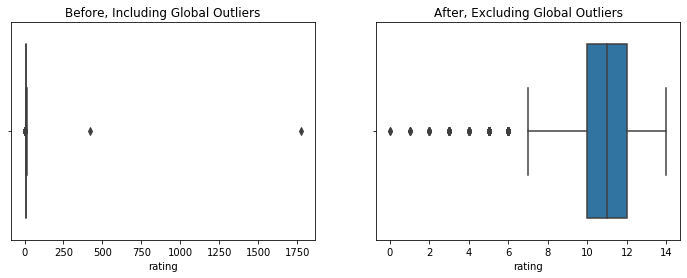

In [80]:
df_before= df_cln.copy()
df_after = df_cln[df_cln['rating'] < 15]

#df_before= plots of the distribution of the data before and after removing the two outliers
f, axes = plt.subplots(1, 2, figsize=(12,4))

sns.boxplot(data=df_before,x= 'rating',orient='w', ax=axes[0])
axes[0].set_title('Before, Including Global Outliers')


sns.boxplot(data=df_after, x= 'rating',orient='w', ax=axes[1])
axes[1].set_title('After, Excluding Global Outliers');

In [81]:
df_rate = df_after.copy()

In [82]:
df_rate['p1'].value_counts()

golden retriever      138
labrador retriever     92
pembroke               88
chihuahua              79
pug                    54
                     ... 
ibex                    1
bonnet                  1
ping-pong ball          1
killer whale            1
african grey            1
Name: p1, Length: 372, dtype: int64

In [83]:
dog_types = df_rate['p1'].value_counts().keys()
dog_types = list(dog_types)

In [84]:
dog_types = dog_types[:len(dog_types)]

In [85]:
for d in dog_types:
    df_other = df_rate[(df_rate.p1 != d)]

df_other = df_other.rating.value_counts().sort_index()
df_other = df_other.rename_axis('rating').to_frame('other')

for d in dog_types:
    df_add = df_rate[df_rate['p1'] == d ]
    df_add = df_add.rating.value_counts().sort_index()
    df_add = df_add.rename_axis('rating').to_frame(d)
    df_other = df_other.merge(df_add, on='rating',how='left').fillna(0)
    

df_other.loc[:,'Total'] = df_other.sum(axis=1)
df_other.index = df_other.index.map(str)
df_other.columns = [x.lower() for x in df_other.columns]
df_all = df_other.copy()
df_all

,other,golden retriever,labrador retriever,pembroke,chihuahua,pug,chow,samoyed,pomeranian,toy poodle,...,zebra,hammer,limousine,cheeseburger,ibex,bonnet,ping-pong ball,killer whale,african grey,total
rating,,,,,,,,,,,,,,,,,,,,,
0,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0
1,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.0
2,9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,18.0
3,19,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,38.0
4,15,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,30.0
5,32,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,64.0
6,32,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,64.0
7,51,0.0,1.0,1.0,4.0,2.0,0.0,1.0,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,102.0
8,95,2.0,3.0,1.0,3.0,2.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,190.0


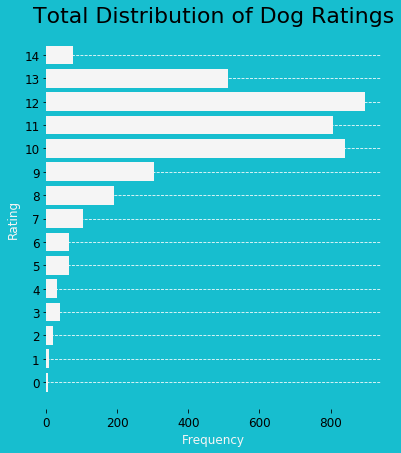

In [86]:
b='Black'
r = df_all.index
t = df_all.total
c= sns.color_palette()[9]
f_sz=12
w='whitesmoke'
fig = plt.figure(figsize=(6,7), facecolor=c)

            
ax = plt.subplot(1, 1, 1)
plt.barh(range(len(r)),t, color=w)
plt.yticks(range(len(r)),r,fontsize=12, color=b)
plt.ylabel('Rating',color=w,fontsize=f_sz)
plt.xticks(color=b,fontsize=f_sz)
plt.xlabel('Frequency',color=w,fontsize=f_sz)
plt.title('Total Distribution of Dog Ratings',color='Black',fontsize=22)

ax.set_axisbelow(True)
ax.yaxis.grid(color='white', linestyle='dashed')
plt.box(False)
plt.show()

- With the outliers removed you can see that the total distribution of the WeRateDogs is skew the left (since the ratings are group in descending order). 
- The lower values are not nearly as common as the ratings that are either 10/10 or greater than 10/10. Ratings of 10, 11, and 12 are quite common. 
- 14/10 happens at a much less frequent manner. Below, I will look more into the specific rating of 14 and see which breeds were most likely to receive it.  


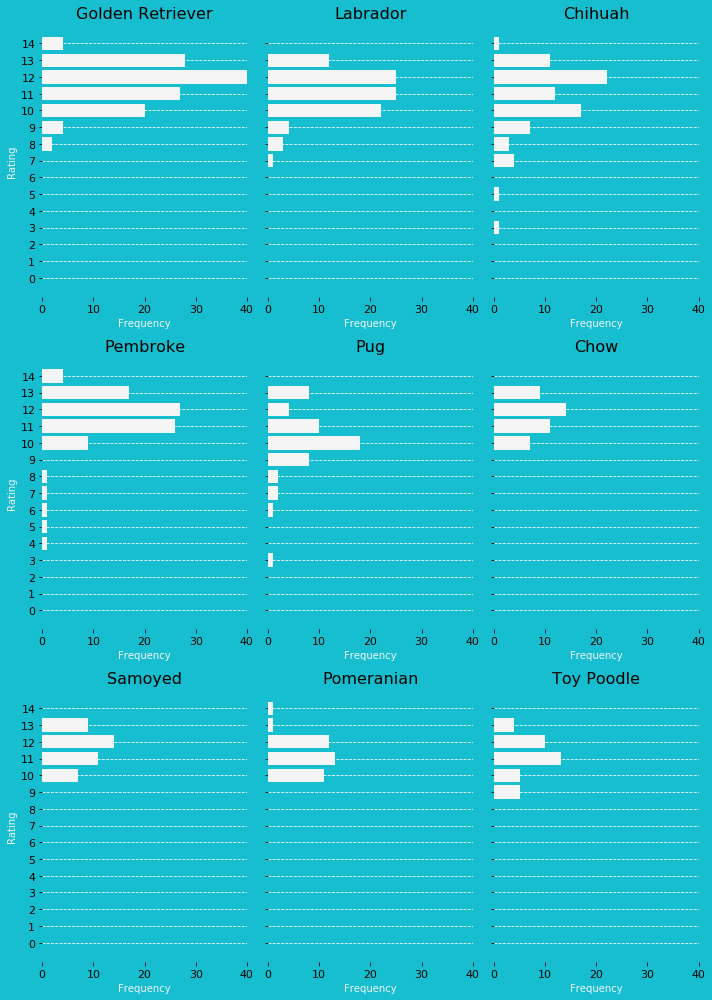

In [87]:
from mpl_toolkits.axes_grid1 import Grid
i = df_all.index
t = df_all.total
r = df_all.index
ch = df_all.chihuahua
g = df_all['golden retriever']
l = df_all['labrador retriever']
p = df_all.pembroke
pu = df_all.pug
ow = df_all.chow
s = df_all.samoyed
pm = df_all.pomeranian
tp = df_all['toy poodle']
c= sns.color_palette()[9]
w='whitesmoke'
b='Black'
f_sz=16
lim = [0,40]
fig = plt.figure(figsize=(10,14), facecolor=c)
grid = Grid(fig, rect=111, nrows_ncols=(2,2),
            axes_pad=0.25, label_mode='L')


# Preferences and labels of Plot 1

ax1= plt.subplot(3, 3, 1)
plt.barh(range(len(r)),g, color=w)
plt.yticks(range(len(r)),r,fontsize=11,color=b)
plt.xticks(color=b,fontsize=11)
plt.xlabel('Frequency',color=w)
plt.ylabel('Rating',color=w)
plt.box(False)
plt.title('Golden Retriever',fontsize=f_sz,color=b)
plt.xlim(lim)
ax1.set_axisbelow(True)
ax1.yaxis.grid(color='white', linestyle='dashed')

# Preferences and labels of Plot 2

ax2= plt.subplot(3, 3, 2)
plt.barh(range(len(r)),l, color=w)
plt.yticks(range(len(r)),r)
plt.xticks(color=b, fontsize=11)
plt.xlabel('Frequency',color=w)
plt.setp(ax2.get_yticklabels(), visible=False)
plt.box(False)
plt.title('Labrador',fontsize=f_sz,color=b)
plt.xlim(lim)
ax2.set_axisbelow(True)
ax2.yaxis.grid(color='white', linestyle='dashed')

# Preferences and labels of Plot 3

ax3 = plt.subplot(3, 3, 3)
plt.barh(range(len(r)),ch, color=w)
plt.yticks(range(len(r)),r)
plt.xticks(color=b, fontsize=11)
plt.xlabel('Frequency',color=w)
plt.setp(ax3.get_yticklabels(), visible=False)
plt.box(False)
plt.title('Chihuah',fontsize=f_sz,color=b)
plt.xlim(lim)
ax3.set_axisbelow(True)
ax3.yaxis.grid(color='white', linestyle='dashed')

# Preferences and labels of Plot 4

ax4 = plt.subplot(3, 3, 4)
plt.barh(range(len(r)),p, color=w)
plt.yticks(range(len(r)),r,fontsize=11,color=b)
plt.xticks(color=b, fontsize=11)
plt.xlabel('Frequency',color=w)
plt.ylabel('Rating',color=w)
plt.box(False)
plt.title('Pembroke',fontsize=f_sz,color=b)
plt.xlim(lim)
ax4.set_axisbelow(True)
ax4.yaxis.grid(color='white', linestyle='dashed')

# Preferences and labels of Plot 5

ax5 = plt.subplot(3, 3, 5)
plt.barh(range(len(r)),pu, color=w)
plt.yticks(range(len(r)),r)
plt.xticks(color=b, fontsize=11)
plt.xlabel('Frequency',color=w)
plt.setp(ax5.get_yticklabels(), visible=False)
plt.box(False)
plt.title('Pug', fontsize=f_sz, color=b)
plt.xlim(lim)
ax5.set_axisbelow(True)
ax5.yaxis.grid(color='white', linestyle='dashed')

# Preferences and labels of Plot 6

ax6 = plt.subplot(3, 3, 6)
plt.barh(range(len(r)),ow, color=w)
plt.yticks(range(len(r)),r)
plt.xticks(color=b, fontsize=11)
plt.xlabel('Frequency',color=w)
plt.setp(ax6.get_yticklabels(), visible=False)
plt.box(False)
plt.title('Chow', fontsize=f_sz, color=b)
plt.xlim(lim)
ax6.set_axisbelow(True)
ax6.yaxis.grid(color='white', linestyle='dashed')


# Preferences and labels of Plot 7

ax7 = plt.subplot(3, 3, 7)
plt.barh(range(len(r)),ow, color=w)
plt.yticks(range(len(r)),r,fontsize=11,color=b)
plt.xticks(color=b, fontsize=11)
plt.xlabel('Frequency',color=w)
plt.ylabel('Rating',color=w)
plt.setp(ax7.get_yticklabels(), visible=True)
plt.box(False)
plt.title('Samoyed', fontsize=f_sz, color=b)
plt.xlim(lim)
ax7.set_axisbelow(True)
ax7.yaxis.grid(color='white', linestyle='dashed')

# Preferences and labels of Plot 8

ax8 = plt.subplot(3, 3, 8)
plt.barh(range(len(r)),pm, color=w)
plt.yticks(range(len(r)),r,)
plt.xticks(color=b, fontsize=11)
plt.xlabel('Frequency',color=w)
plt.setp(ax8.get_yticklabels(), visible=False)
plt.box(False)
plt.title('Pomeranian', fontsize=f_sz, color=b)
plt.xlim(lim)
ax8.set_axisbelow(True)
ax8.yaxis.grid(color='white', linestyle='dashed')

# Preferences and labels of Plot 9


ax9 = plt.subplot(3, 3, 9)
plt.barh(range(len(r)),tp, color=w)
plt.yticks(range(len(r)),r,)
plt.xticks(color=b, fontsize=11)
plt.xlabel('Frequency',color=w)
plt.setp(ax9.get_yticklabels(), visible=False)
plt.box(False)
plt.title('Toy Poodle', fontsize=f_sz, color=b)
plt.xlim(lim)
ax9.set_axisbelow(True)
ax9.yaxis.grid(color='white', linestyle='dashed')

# Display all barcharts 

plt.tight_layout()
plt.show()

- This plot categorizes the distributions by dog breeds, showing a wide disparity between the frequency of ratings.
At the top, Golden Retriever appears to consistently outperform the other breeds, receiving the most 14’s, 13, and 12’s. The frequency of ratings also shows that the most common dog breed detected in the data set was Golden Retriever, with a count of 138 out of the 1977. 
- Another observation that can be taken away from this plot was that WeRateDogs had a consistent pattern of rating all dogs at or above 10 out of 10, regardless of breed. Although, they did like picking on the occasional Pug or Chihuah, who have suspiciously received a few more 7 to 3 ratings than the others


## Bayesian Probability of Dog Ratings for the Top 5 Dog Types
<a id="jump3"> </a>

Once the data was discrete and the frequencies were gathered I could then use what I know about how WeRateDogs twitter account rates each dog breed and derive a probability table. 

In [88]:
# Gathering Each dogtypes value counts by Rating

#Golden Retriever
df_gold= (df_rate[df_rate['p1']=='golden retriever'])
df_gold= df_gold.rating.value_counts().sort_index()
df_gold = df_gold.rename_axis('rating').to_frame('gold_count')
#Labrador Retriever
df_lab= (df_rate[df_rate['p1']=='labrador retriever'])
df_lab= df_lab.rating.value_counts().sort_index()
df_lab = df_lab.rename_axis('rating').to_frame('lab_count')
#Pembroke
df_pem= (df_rate[df_rate['p1']=='pembroke'])
df_pem=df_pem.rating.value_counts().sort_index()
df_pem = df_pem.rename_axis('rating').to_frame('pem_count')
#Chihuahua
df_chih= (df_rate[df_rate['p1']=='chihuahua'])
df_chih= df_chih.rating.value_counts().sort_index()
df_chih = df_chih.rename_axis('rating').to_frame('chih_count')
#Pug
df_pug= (df_rate[df_rate['p1']=='pug'])
df_pug=df_pug.rating.value_counts().sort_index()
df_pub=df_pug.rename_axis('rating').to_frame('pug_count')

#Combining the top 5 most likley dogs
df_5dogs= pd.concat([df_pem,df_gold, df_lab,df_chih,df_pug],axis=1,sort=True).fillna(0)
df_5dogs= df_5dogs.reset_index().rename(columns={'index' : 'rating','rating' : 'pug_count'})

#Counts of all other dogs and ratings
df_oth = df_rate[(df_rate.p1 != 'golden retriever') & (df_rate.p1 != 'labrador retriever') & (df_rate.p1 !='chihuahua')& (df_rate.p1 !='pembroke')& (df_rate.p1 !='pug')]
df_oth = df_oth.rating.value_counts().sort_index()
df_oth = df_oth.rename_axis('rating').to_frame('other_count')


#Combining the all rating counts
df_bayes= pd.merge(df_oth, df_5dogs,on='rating',how='left').fillna(0)
df_bayes['rating'] = df_bayes['rating'].astype(str)
df_bayes= df_bayes.set_index('rating',drop=True)
df_bayes.loc[:,'Total'] = df_bayes.sum(axis=1)
df_bayes.loc['Total',:] = df_bayes.sum(axis=0)

df_bayes

,other_count,pem_count,gold_count,lab_count,chih_count,pug_count,Total
rating,,,,,,,
0,2.0,0.0,0.0,0.0,0.0,0.0,2.0
1,4.0,0.0,0.0,0.0,0.0,0.0,4.0
2,9.0,0.0,0.0,0.0,0.0,0.0,9.0
3,17.0,0.0,0.0,0.0,1.0,1.0,19.0
4,14.0,1.0,0.0,0.0,0.0,0.0,15.0
5,30.0,1.0,0.0,0.0,1.0,0.0,32.0
6,30.0,1.0,0.0,0.0,0.0,1.0,32.0
7,43.0,1.0,0.0,1.0,4.0,2.0,51.0
8,84.0,1.0,2.0,3.0,3.0,2.0,95.0


In [89]:
#Deriving given calculations for the Baysian Probability Output
df_given = df_bayes.copy()
for col in df_given.columns:
    for i,row in df_given.iterrows():
        given = row[col]/ row['Total']
        df_given.loc[i,col] = given
#Transpositoning the matrix
df_prior = df_bayes.copy()
df_prior = df_prior.T
#Deriving prior calculations
df_pri = df_prior.copy()
for col in df_prior.columns:
    for i,row in df_prior.iterrows():
        fix = row[col]
        prior = fix / row['Total']
        df_pri.loc[i,col] = prior

#Multiplying to create probability distribution        
df_prob = df_given * df_pri.T
df_prob = df_prob.round(3)
df_prob

,other_count,pem_count,gold_count,lab_count,chih_count,pug_count,Total
rating,,,,,,,
0,0.001,0.000,0.000,0.000,0.000,0.000,0.001
1,0.003,0.000,0.000,0.000,0.000,0.000,0.002
2,0.006,0.000,0.000,0.000,0.000,0.000,0.005
3,0.010,0.000,0.000,0.000,0.001,0.001,0.010
4,0.009,0.001,0.000,0.000,0.000,0.000,0.008
5,0.018,0.000,0.000,0.000,0.000,0.000,0.016
6,0.018,0.000,0.000,0.000,0.000,0.001,0.016
7,0.024,0.000,0.000,0.000,0.004,0.001,0.026
8,0.049,0.000,0.000,0.001,0.001,0.001,0.048


In [90]:
df_prob

,other_count,pem_count,gold_count,lab_count,chih_count,pug_count,Total
rating,,,,,,,
0,0.001,0.000,0.000,0.000,0.000,0.000,0.001
1,0.003,0.000,0.000,0.000,0.000,0.000,0.002
2,0.006,0.000,0.000,0.000,0.000,0.000,0.005
3,0.010,0.000,0.000,0.000,0.001,0.001,0.010
4,0.009,0.001,0.000,0.000,0.000,0.000,0.008
5,0.018,0.000,0.000,0.000,0.000,0.000,0.016
6,0.018,0.000,0.000,0.000,0.000,0.001,0.016
7,0.024,0.000,0.000,0.000,0.004,0.001,0.026
8,0.049,0.000,0.000,0.001,0.001,0.001,0.048


Using the probability table I could then calculate the bayesian conditional probability of how likely each rating was given the dog’s breed. 

In [91]:
rating_given_gold = df_prob['gold_count'] / df_prob.loc['Total','gold_count']
rating_given_gold.drop('Total',inplace=True)

In [92]:
rating_given_gold

rating
0     0.000000
1     0.000000
2     0.000000
3     0.000000
4     0.000000
5     0.000000
6     0.000000
7     0.000000
8     0.000000
9     0.014286
10    0.100000
11    0.185714
12    0.642857
13    0.314286
14    0.042857
Name: gold_count, dtype: float64

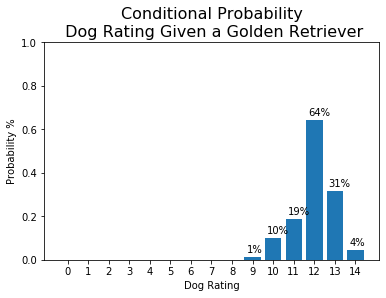

In [93]:
counts = rating_given_gold.values

plt.bar(rating_given_gold.keys(),rating_given_gold.values)
plt.ylim([0, 1])
plt.xlabel('Dog Rating')
plt.ylabel('Probability %')

for i in range(len(counts)):
    val = counts[i]*100
    if val < 0.01:
        pass
    else:
        plt.text(i -.3, counts[i]+.02, s=f"{val:.0f}%",color='black')


plt.title('Conditional Probability\n Dog Rating Given a Golden Retriever',fontsize=f_sz,color=b)        
plt.show()

- I found that if a Golden Retriever is posted on WeRateDogs it has a 1% chance of receiving a rating of 9, a 10% chance of receiving a 10, a 19% of receiving an 11, but the rating the Golden Retriever is most likely to receive is a 12 out of 10, which has a probability 64%. The likelihood of receiving a rating of 12 is more than twice as likely as the next most likely rating
- At the highest end of the spectrum, a Golden Retriever has a 31% chance of receiving a 13 and a 4% chance of receiving a rating of 14. Next up I will take a look at the inverse conditional probabilities, the liklihood of the dog breed given that the rating is a 13 as well as the likelihood of the dog breed given the rating is a 14.

In [94]:
df_bayes.T

rating,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,Total
other_count,2.0,4.0,9.0,17.0,14.0,30.0,30.0,43.0,84.0,129.0,335.0,304.0,318.0,179.0,28.0,1526.0
pem_count,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,9.0,26.0,27.0,17.0,4.0,88.0
gold_count,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,4.0,20.0,27.0,53.0,28.0,4.0,138.0
lab_count,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,3.0,4.0,22.0,25.0,25.0,12.0,0.0,92.0
chih_count,0.0,0.0,0.0,1.0,0.0,1.0,0.0,4.0,3.0,7.0,17.0,12.0,22.0,11.0,1.0,79.0
pug_count,0.0,0.0,0.0,1.0,0.0,0.0,1.0,2.0,2.0,8.0,18.0,10.0,4.0,8.0,0.0,54.0
Total,2.0,4.0,9.0,19.0,15.0,32.0,32.0,51.0,95.0,152.0,421.0,404.0,449.0,255.0,37.0,1977.0


In [95]:
df_prob.T

rating,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,Total
other_count,0.001,0.003,0.006,0.010,0.009,0.018,0.018,0.024,0.049,0.072,0.175,0.150,0.148,0.082,0.014,0.772
pem_count,0.000,0.000,0.000,0.000,0.001,0.000,0.000,0.000,0.000,0.000,0.002,0.019,0.018,0.013,0.005,0.045
gold_count,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.001,0.007,0.013,0.045,0.022,0.003,0.070
lab_count,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.001,0.001,0.012,0.017,0.015,0.006,0.000,0.047
chih_count,0.000,0.000,0.000,0.001,0.000,0.000,0.000,0.004,0.001,0.004,0.009,0.005,0.014,0.006,0.000,0.040
pug_count,0.000,0.000,0.000,0.001,0.000,0.000,0.001,0.001,0.001,0.008,0.014,0.005,0.001,0.005,0.000,0.027
Total,0.001,0.002,0.005,0.010,0.008,0.016,0.016,0.026,0.048,0.077,0.213,0.204,0.227,0.129,0.019,1.000


In [96]:
breed_given_14 = df_prob.T['14'] / df_prob.T.loc['Total','14']
breed_given_14.drop('Total',inplace=True)

changename = {'other_count': 'Other breeds','pem_count':'Pembroke','gold_count':'Golden Retriever','lab_count':'Labrador',
              'chih_count':'Chihuah', 'pug_count': 'Pug'}

for name in changename:
    breed_given_14[changename[name]] = breed_given_14.pop(name)

In [97]:
breed_given_14

Other breeds        0.736842
Pembroke            0.263158
Golden Retriever    0.157895
Labrador            0.000000
Chihuah             0.000000
Pug                 0.000000
Name: 14, dtype: float64

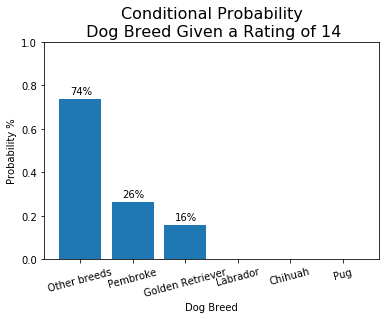

In [98]:
counts = breed_given_14.values

plt.bar(breed_given_14.keys(),breed_given_14.values)
plt.xticks(rotation=15)
plt.ylim([0, 1])
plt.xlabel('Dog Breed')
plt.ylabel('Probability %')


for i in range(len(counts)):
    val = counts[i]*100
    if val < 0.01:
        pass
    else:
        plt.text(i -.2, counts[i]+.02, s=f"{val:.0f}%",color='black')

plt.title('Conditional Probability\n Dog Breed Given a Rating of 14',fontsize=f_sz,color=b)    
plt.show()

In [99]:
breed_given_13 = df_prob.T['13'] / df_prob.T.loc['Total','13']
breed_given_13.drop('Total',inplace=True)

changename = {'other_count': 'Other breeds','pem_count':'Pembroke','gold_count':'Golden Retriever','lab_count':'Labrador',
              'chih_count':'Chihuah', 'pug_count': 'Pug'}

for name in changename:
    breed_given_13[changename[name]] = breed_given_13.pop(name)

In [100]:
breed_given_13

Other breeds        0.635659
Pembroke            0.100775
Golden Retriever    0.170543
Labrador            0.046512
Chihuah             0.046512
Pug                 0.038760
Name: 13, dtype: float64

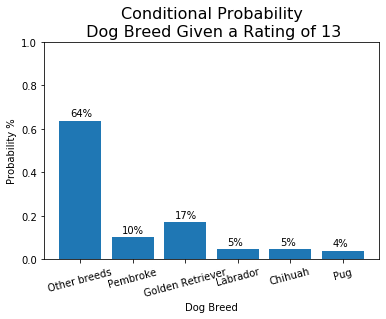

In [101]:
counts = breed_given_13.values

plt.bar(breed_given_13.keys(),breed_given_13.values)
plt.xticks(rotation=15)
plt.ylim([0, 1])
plt.xlabel('Dog Breed')
plt.ylabel('Probability %')


for i in range(len(counts)):
    val = counts[i]*100
    if val < 0.01:
        pass
    else:
        plt.text(i -.2, counts[i]+.02, s=f"{val:.0f}%",color='black')

plt.title('Conditional Probability\n Dog Breed Given a Rating of 13',fontsize=f_sz,color=b)    
plt.show()

- No matter how likely one of the top 5 breeds were to get a 14 or 13, it is more likely to be part of the Other breeds category, once the cululative probabilities are all added together. The likelihood a rating of 14 or 13 was for a dog who was not part of the top 5 breeds was 74% and 64%, respectfully. 
- Given that the rating was a 14, the liklihood that the dog is a Golden Retriever is 16%. The liklihood that the dog’s breed is a Pembroke is 26%, siginifcantly higher than the Golden Retriever even though they both had 4 ratings of 14.  Even though both breeds had the same amount of 14 ratings, the Pembroke had just over half as many observations in the dataset, 88, compared to Golden Retrievers 138 count. 


## Time Series of WeRateDogs Tweets
<a id="jump4"> </a>

In [102]:
df_sort = df_cln.copy()

In [103]:
df_sort = df_sort.set_index('timestamp')
df_sort.sort_index(ascending=True, inplace=True)
df_sort.reset_index(inplace=True)

Last I will look at which tweet received the most favorites and retweets

In [104]:
df_sort.favorite_count.max(), df_sort.retweet_count.max()

(160445, 80263)

In [105]:
mostfaves = df_sort.loc[df_sort.favorite_count == df_sort.favorite_count.max()].index
mostretweets = df_sort.loc[df_sort.retweet_count == df_sort.retweet_count.max()].index

Now to check if the most favorites and the most retweets were on the same tweet. 

In [106]:
bool(mostfaves == mostretweets)

True

In [107]:
date = df_sort.timestamp[mostretweets]
text = df_sort.text[mostretweets]

In [108]:
codydate = str(date.values).replace('\\n ','')
codydate = codydate[2:14]

In [109]:
print(f'{codydate}\n{text.values}')

2016/06/18 1
["Here's a doggo realizing you can stand in a pool. 13/10 enlightened af (vid by Tina Conrad) "]


This doggo learned how to stand in the pool and earned himself the most favorites & retweets of all the dogs on WeRateDogs.

<img src="mostfaves.jpg"/>

This doggo above is named Cody (Cody is his real name if you watch his now famous video).  Cody learned how to stand in the pool and earned himself the most favorites & retweets of all the dogs on WeRateDogs within this dataset. Cody’s tweet really took off when it was tweeted out on June 18th of 2016, long before it was common for WeRateDogs tweets to receive this level of activity, receiving 80, 263 retweets and 160,445 favorites. Good boy, Cody. 


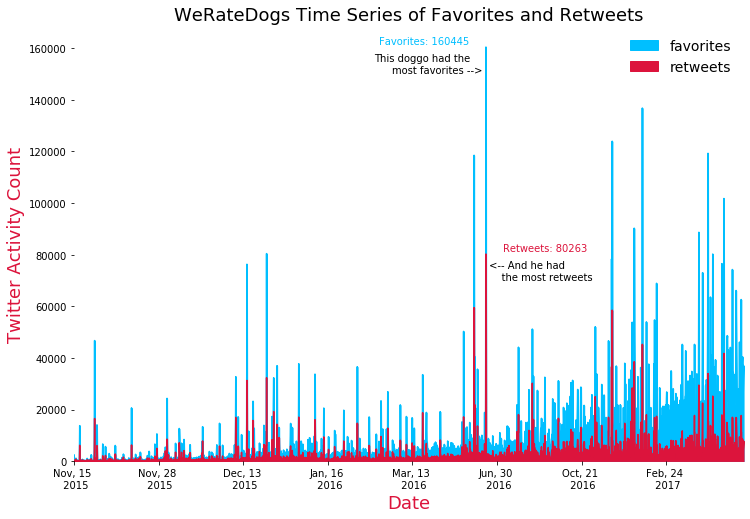

In [110]:
#formatting the datetime for the x axis

dates = pd.to_datetime(df_sort.timestamp)
df_sort.timestamp= dates.apply(lambda x: x.strftime('%b, %d \n %Y'))

#saving variables to be included in twitter activity visualization

numfaves = df_sort.favorite_count.max()
numretweets = df_sort.retweet_count.max()
codydate =  f'Date: {codydate}'
codyfaves = f'Favorites: {numfaves}'
codyretweets = f'Retweets: {numretweets}'
ind = mostretweets.values


# TimeSeries of Twitter Activity 

#Favorite and Retweet series
time_faves = pd.Series(data=df_sort['favorite_count'].values, index=df_sort.timestamp)
time_retweets = pd.Series(data=df_sort['retweet_count'].values, index=df_sort.timestamp)

#Plotting both series to the same axis
size= (12,8)

time_faves.plot(kind='area',figsize=size, label='favorites',
                color='deepskyblue',legend=True)
time_retweets.plot(kind='area',figsize=size, label='retweets',
                   color='crimson',legend=True)

#Labels and preferences for the visualization

plt.title('WeRateDogs Time Series of Favorites and Retweets',fontsize=18)
plt.xlabel('Date',fontsize=18,color='crimson') 
plt.ylabel('Twitter Activity Count',fontsize=18, color='crimson')
plt.xticks(rotation=0)
plt.legend(fontsize=14,frameon=False)


plt.text(ind,numfaves -10000,'This doggo had the     \nmost favorites --> ',horizontalalignment='right')
plt.text(ind,numretweets -10000,' <-- And he had \n     the most retweets',horizontalalignment='left')
plt.text(ind - 50, numfaves + 1200, codyfaves,horizontalalignment='right',color='deepskyblue')
plt.text(ind + 50, numretweets + 1200, codyretweets,horizontalalignment='left',color='crimson')



plt.box(False)
plt.show();

From 2015 to Spring of 2016, WeRateDogs had relatively modest twitter traffic.  The page did make a few jumps over the 80,000 favorite threshold in December of 2015, but it took until the end of 2016 for the account to consistently hit their over 100,000 favorite count per tweet that they are now accustom to.


References and Thanks to:
<ul><li>https://www.kite.com/python/answers/how-to-rename-a-dictionary-key-in-python
<li>https://realpython.com/iterate-through-dictionary-python/
<li>https://stackoverflow.com/questions/14494747/how-to-add-images-to-readme-md-on-github
<li>https://www.oreilly.com/library/view/python-data-science/9781491912126/ch04.html
    <li>https://www.shanelynn.ie/merge-join-dataframes-python-pandas-index-1/
    <li>https://thispointer.com/pandas-apply-apply-a-function-to-each-row-column-in-dataframe/
    <li>https://stackoverflow.com/questions/20804673/appending-column-totals-to-a-pandas-dataframe
    <li>https://towardsdatascience.com/how-to-make-bar-and-hbar-charts-with-labels-using-matplotlib-b701ce70ba9c
    <li>https://www.geeksforgeeks.org/highlight-the-nan-values-in-pandas-dataframe/
    <li> https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html
        </li>
    </ul>